In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV

# Load and slice MNIST dataset

code ref : [url](https://stackoverflow.com/questions/52108685/is-it-possible-to-only-load-part-of-mnist-or-other-tuples)

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


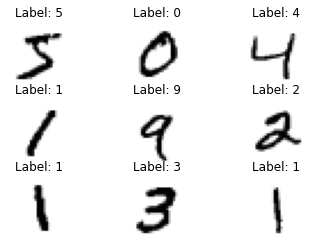

In [3]:
# plot first 9 images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.cm.gray_r)
	plt.axis('off')
	plt.title('Label: {}'.format(y_train[i]))
plt.show()

In [4]:
# flatten the features from 28*28 pixel to 784 wide vector
X_train = np.reshape(X_train, (-1, 784)).astype('float32')
X_test = np.reshape(X_test, (-1, 784)).astype('float32')

In [5]:
# keep 10 percent of the data
slice_ratio = 10
X_train = X_train[:X_train.shape[0]//slice_ratio,:]
y_train = y_train[:y_train.shape[0]//slice_ratio]
X_test = X_test[:X_test.shape[0]//slice_ratio,:]
y_test = y_test[:y_test.shape[0]//slice_ratio]

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(6000, 784), y=(6000,)
Test: X=(1000, 784), y=(1000,)


# (a) Linear SVM

ref : The uploaded ClassicalMachineLearning.ipynb notebook in course material

In [6]:
#train
linear_model = svm.SVC(kernel='linear')
linear_model.fit(X_train, y_train)
#Evaluate
y_pred = linear_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on the test dataset: {}".format(acc))

Accuracy on the test dataset: 0.888


# (b) RBF-SVM 

In [7]:
#train
rbf_model = svm.SVC(kernel='rbf')
rbf_model.fit(X_train, y_train)
#Evaluate
y_pred = rbf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: ", acc)

Accuracy on the test data:  0.938


# (c) Default parametrs of RBF-SVM in sklearn:  

ref: [url](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [article](https://www.researchgate.net/publication/343903629_How_to_tune_the_RBF_SVM_hyperparameters_An_empirical_evaluation_of_18_search_algorithms)


*   C: float, default=1.0
>   Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
>   A *lower* C will allow more support vectors, resulting in larger margins.

*   gamma: {‘scale’, ‘auto’} or float, default=’scale’
>   Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. As gamma increases, the decision surfaces become more ”curvy” and fit closely to the training data.
>   *   if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var())as value of gamma,
>   *   if ‘auto’, uses 1 / n_features.












In [8]:
print("default gamma: ", 1 / (X_train.shape[1] * X_train.var()))

default gamma:  2.054710503690529e-07


# (d) Hyperparameter Tuning

Based on [article](https://www.researchgate.net/publication/343903629_How_to_tune_the_RBF_SVM_hyperparameters_An_empirical_evaluation_of_18_search_algorithms) I used the following search space and bounds for C and gamma:

$$
Space: \log_2 C × \log_2 gamma \\
Bounds: \ 2^{-5} ≤ C ≤ 2^{15} ,
\ 2^{-15} ≤ gamma ≤ 2^{3} 
$$

 

*   In the grid search the logarithmic space is divided into an equally spaced grid and only the pairs in the grid points are tested.
*   In random search N random points are uniformly sampled from the logarithmic spacewithin the defined bounds.



In [9]:
C_range = np.logspace(-5, 15, 13)
gamma_range = np.logspace(-15, 3, 13)
param_space = dict(gamma=gamma_range, C=C_range)

Grid search

In [10]:
grid_start = time.time()
grid_search = GridSearchCV(svm.SVC(), param_grid=param_space, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_end = time.time()
print('Best parameters: ', grid_search.best_params_, '\n with the accuracy :', grid_search.best_score_)

Best parameters:  {'C': 46.41588833612782, 'gamma': 3.162277660168379e-08} 
 with the accuracy : 0.9406666666666667


Random search

In [11]:
rnd_start = time.time()
rnd_search = RandomizedSearchCV(svm.SVC(), param_space, n_jobs=-1)
rnd_search.fit(X_train, y_train)
rnd_end = time.time()
print('Best parameters: ', rnd_search.best_params_, '\n with the accuracy :', rnd_search.best_score_)

Best parameters:  {'gamma': 1e-06, 'C': 10000000000.0} 
 with the accuracy : 0.9391666666666667


# (e) Computational efficiency 

In [12]:
print('Grid Search Execution Time: ', grid_end - grid_start)
print('Random Search Execution Time: ', rnd_end - rnd_start)

Grid Search Execution Time:  8919.056124687195
Random Search Execution Time:  620.7428193092346


# (f) RBF_SVM with optimal hyperparameters

Grid Search

In [13]:
#train
rbf_model = svm.SVC(kernel='rbf', gamma=grid_search.best_params_['gamma'], C=grid_search.best_params_['C'])
rbf_model.fit(X_train, y_train)
#Evaluate
y_pred = rbf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: ", acc)

Accuracy on the test data:  0.933


Random Search

In [14]:
#train
rbf_model = svm.SVC(kernel='rbf', gamma=rnd_search.best_params_['gamma'], C=rnd_search.best_params_['C'])
rbf_model.fit(X_train, y_train)
#Evaluate
y_pred = rbf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: ", acc)

Accuracy on the test data:  0.939


The grid search method is so computationally expensive (14 times higher than the random search method) and the final accuracies with the optimal hyperparameters are almost the same. So overall, the random search method can be more efficient while keeping the high performance.